In [1]:
import unipercept as up
import os

ENV_DATASETS = "UNICORE_DATASETS"
from pathlib import Path

os.environ.setdefault(ENV_DATASETS, str(Path("../datasets").resolve()))

print(f"Datasets directory: {os.getenv(ENV_DATASETS)}")
print(f"Available datasets: " + ", ".join(up.data.sets.list_datasets()))
# ds = up.data.sets.get_dataset("cityscapes/vps")(
#     queue_fn=up.data.collect.GroupAdjacentTime(
#         2, required_capture_sources=[{"panoptic", "depth", "image"}, set()], use_typecheck=False
#     ),
#     split="train",
#     all=False,
# )
# ds = up.data.sets.get_dataset("pascal-voc")(
#     queue_fn=up.data.collect.ExtractIndividualFrames(), year="2012", download=True
# )
ds = up.data.sets.get_dataset("kitti-360")(queue_fn=up.data.sets.get_default_queue_fn(), split="train")

print(f"Dataset {type(ds).__name__} loaded.")

Datasets directory: /projects/0/einf5438/datasets
Available datasets: huggingface, semkitti/dvps, sem-kitti, cityscapes, kitti-360, cityscapes/vps, mapillary-vistas, kittistep, wild-dash, pascal-voc, kitti/step
[11/12 13:30:24 unipercept.data.collect]: Using adjacent collector (1 frames) with required sources (frozenset({'image'}),)
Dataset KITTI360Dataset loaded.


## Dataset metadata/info

Each dataset _class_ has an attached `info` attribute of type `unipercept.data.types.Metadata`. Below is an example for the currently active dataset (if a `ds` object is defined).

In [2]:
import unipercept as up
from pprint import pformat

print(f"Available info: " + ", ".join(up.data.sets.list_info()))

try:
    print(f"Metadata for {ds.__class__.__name__} @ `ds.info`: " + pformat(ds.info))
except (AttributeError, RuntimeError):
    print(f"No dataset object bound.")

Available info: huggingface, semkitti/dvps, sem-kitti, cityscapes, kitti-360, cityscapes/vps, mapillary-vistas, kittistep, wild-dash, pascal-voc, kitti/step
Metadata for KITTI360Dataset @ `ds.info`: Metadata(label_divisor=1000,
         ignore_label=255,
         fps=15,
         depth_max=80,
         semantic_classes=frozendict({-1: SClass(name='void', color=RGB(r=128, g=64, b=128), kind=<SType.VOID: 0>, unified_id=-1, dataset_id=255, depth_fixed=None), 0: SClass(name='road', color=RGB(r=128, g=64, b=128), kind=<SType.STUFF: 1>, unified_id=0, dataset_id=7, depth_fixed=None), 1: SClass(name='sidewalk', color=RGB(r=244, g=35, b=232), kind=<SType.STUFF: 1>, unified_id=1, dataset_id=8, depth_fixed=None), 2: SClass(name='building', color=RGB(r=70, g=70, b=70), kind=<SType.STUFF: 1>, unified_id=2, dataset_id=11, depth_fixed=None), 3: SClass(name='wall', color=RGB(r=102, g=102, b=156), kind=<SType.STUFF: 1>, unified_id=3, dataset_id=12, depth_fixed=None), 4: SClass(name='fence', color=RGB(r

## Dataset structure

Datasets in `unipercept.data.sets` are structured by three main components. First, the `manifest` is an inventory of all files that are belong to the dataset, or specify methods in which these may be obtained remotely. Second, a `queue` is formed, transforming the `manifest` into a list of records that are loaded from dist or streamed from the internet by the final component: the `datapipe`. This object takes each item in the `queue`, loads the relevant resources from disk, and outputs a `unipercept.data.points.InputData` object.

For simplicity, we strictly enforce that all tasks and modalities are expressed interms of the same structures (queue items and input data). 

Below are some examples of each.

### Manifest

Below is a shortened version of the manifest, showing the structure.

In [3]:
# ds._build_manifest()

from unicore import file_io

print(f"Caches are stored at {file_io.Path('//cache/datasets')}")

Caches are stored at /gpfs/scratch1/shared/kstolle/cache/datasets


In [15]:
from pprint import pformat
import typing as T

mfst = ds.manifest
print(mfst.keys())
print("\n".join(pformat(mfst).splitlines()[:10]))

dict_keys(['sequences', 'timestamp', 'version'])
{'sequences': {'2013_05_28_drive_0000_sync': {'camera': {'focal_length': [0.0,
                                                                          0.0],
                                                         'image_size': [512,
                                                                        1024],
                                                         'principal_point': [0.0,
                                                                             0.0],
                                                         'rotation': [0.0,
                                                                      0.0,
                                                                      0.0],
                                                         'translation': [0.0,


### Queue 

The dataset queue is a version of the dataset with the queue function (`queue_fn`) applied.

In [5]:
from pprint import pprint

pprint(ds.queue[3])

[11/12 13:30:27 unipercept.data.collect]: Found 49004 sequences with 1 captures!
('2013_05_28_drive_0000_sync/image_00/0000000253',
 {'camera': {'focal_length': [0.0, 0.0],
             'image_size': [512, 1024],
             'principal_point': [0.0, 0.0],
             'rotation': [0.0, 0.0, 0.0],
             'translation': [0.0, 0.0, 0.0]},
  'captures': [{'depth': {'meta': {'format': 'safetensors'},
                          'path': '/gpfs/work4/0/einf5438/datasets/kitti-360/data_2d_depth/train/2013_05_28_drive_0000_sync/image_00/mono_depth/0000000253.safetensors'},
                'image': {'path': '/gpfs/work4/0/einf5438/datasets/kitti-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect/0000000253.png'},
                'panoptic': {'meta': {'format': 'vistas'},
                             'path': '/gpfs/work4/0/einf5438/datasets/kitti-360/data_2d_semantics/train/2013_05_28_drive_0000_sync/image_00/instance/0000000253.png'}}],
  'fps': 1.0,
  'frame': 3,
  'sequence': '

### Datapipe

The datapipe loads queue items from the disk.


InputData(
    cameras=CameraModel(
        image_size=Tensor(shape=torch.Size([2]), device=cpu, dtype=torch.int64, is_shared=False),
        matrix=Tensor(shape=torch.Size([1, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        pose=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
        batch_size=torch.Size([]),
        device=None,
        is_shared=False),
    captures=CaptureData(
        depths=Tensor(shape=torch.Size([1, 376, 1408]), device=cpu, dtype=torch.float32, is_shared=False),
        images=Tensor(shape=torch.Size([1, 3, 376, 1408]), device=cpu, dtype=torch.uint8, is_shared=False),
        segmentations=Tensor(shape=torch.Size([1, 376, 1408]), device=cpu, dtype=torch.int64, is_shared=False),
        times=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        batch_size=torch.Size([1]),
        device=None,
        is_shared=False),
    content_boxes=Tensor(shape=torch.Size([4]), device

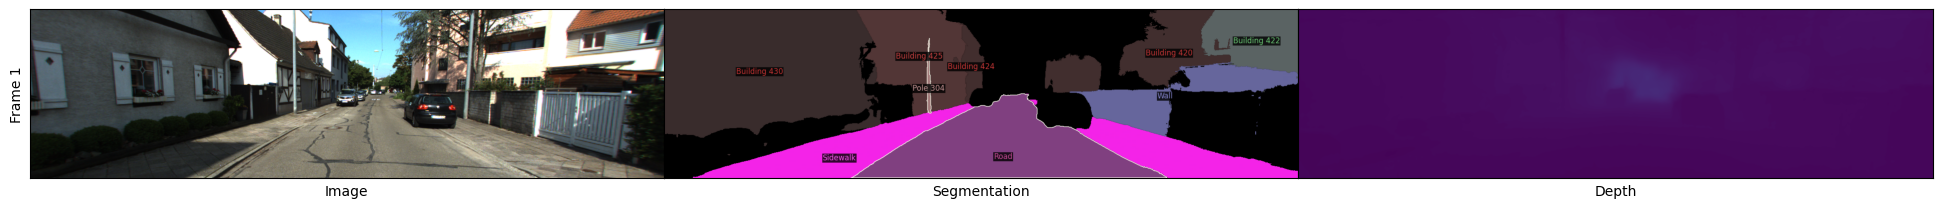

In [9]:
import unipercept as up

dp = ds.datapipe

for inputs in dp.sample(1):
    up.render.utils.plot_input_data(inputs, info=ds.info, height=8)

### Comparison against pseudo-labeled depths

Next, we compare the provided depth maps (if the current datset has them) against generated depth maps and see how the 
distributions overlap.

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


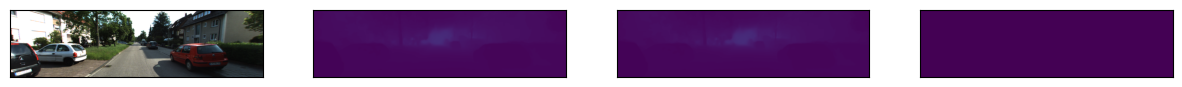

In [7]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.v2.functional import to_pil_image

image = inputs.captures.images[0, :, :, :].clone()
depth_true = inputs.captures.depths[0, :, :].clone()

fig, ax = plt.subplots(1, 4, squeeze=False, figsize=(15, 5))

up.render.utils.draw_image(image, ax=ax[0,0])
up.render.utils.draw_image_depth(depth_true, info=ds.info, ax=ax[0,1])

pseudo_gen = up.data.sets.PseudoGenerator(depth_model="sayakpaul/glpn-kitti-finetuned-diode-221214-123047")
with torch.inference_mode():
    depth_pred = pseudo_gen.estimate_depth(image)
    # Interpolate to original size
    depth_pred = torch.nn.functional.interpolate(
        depth_pred.unsqueeze(1),
        size=image.shape[-2:],
        mode="bicubic",
        align_corners=False,
    )[0, 0, :, :]

    # Ensure that `depth_pred` is in the same range as `depth_true`
    depth_pred[torch.isinf(depth_pred)] = 0.0
    depth_pred[torch.isnan(depth_pred)] = 0.0
    depth_pred *= depth_true.max() / depth_pred[depth_true > 0].max()
    depth_pred.clamp_(min=0.0, max=depth_true.max())

up.render.utils.draw_image_depth(depth_pred, info=ds.info, ax=ax[0,2])

depth_err = (depth_pred - depth_true).abs()
up.render.utils.draw_image_depth(depth_err, info=ds.info, ax=ax[0,3])
fig.show()


## Operations

The next cells demonstrate the operations (`unipercept.data.ops`) module, which we use to apply augmentations to the image and generate pseudo-motion.

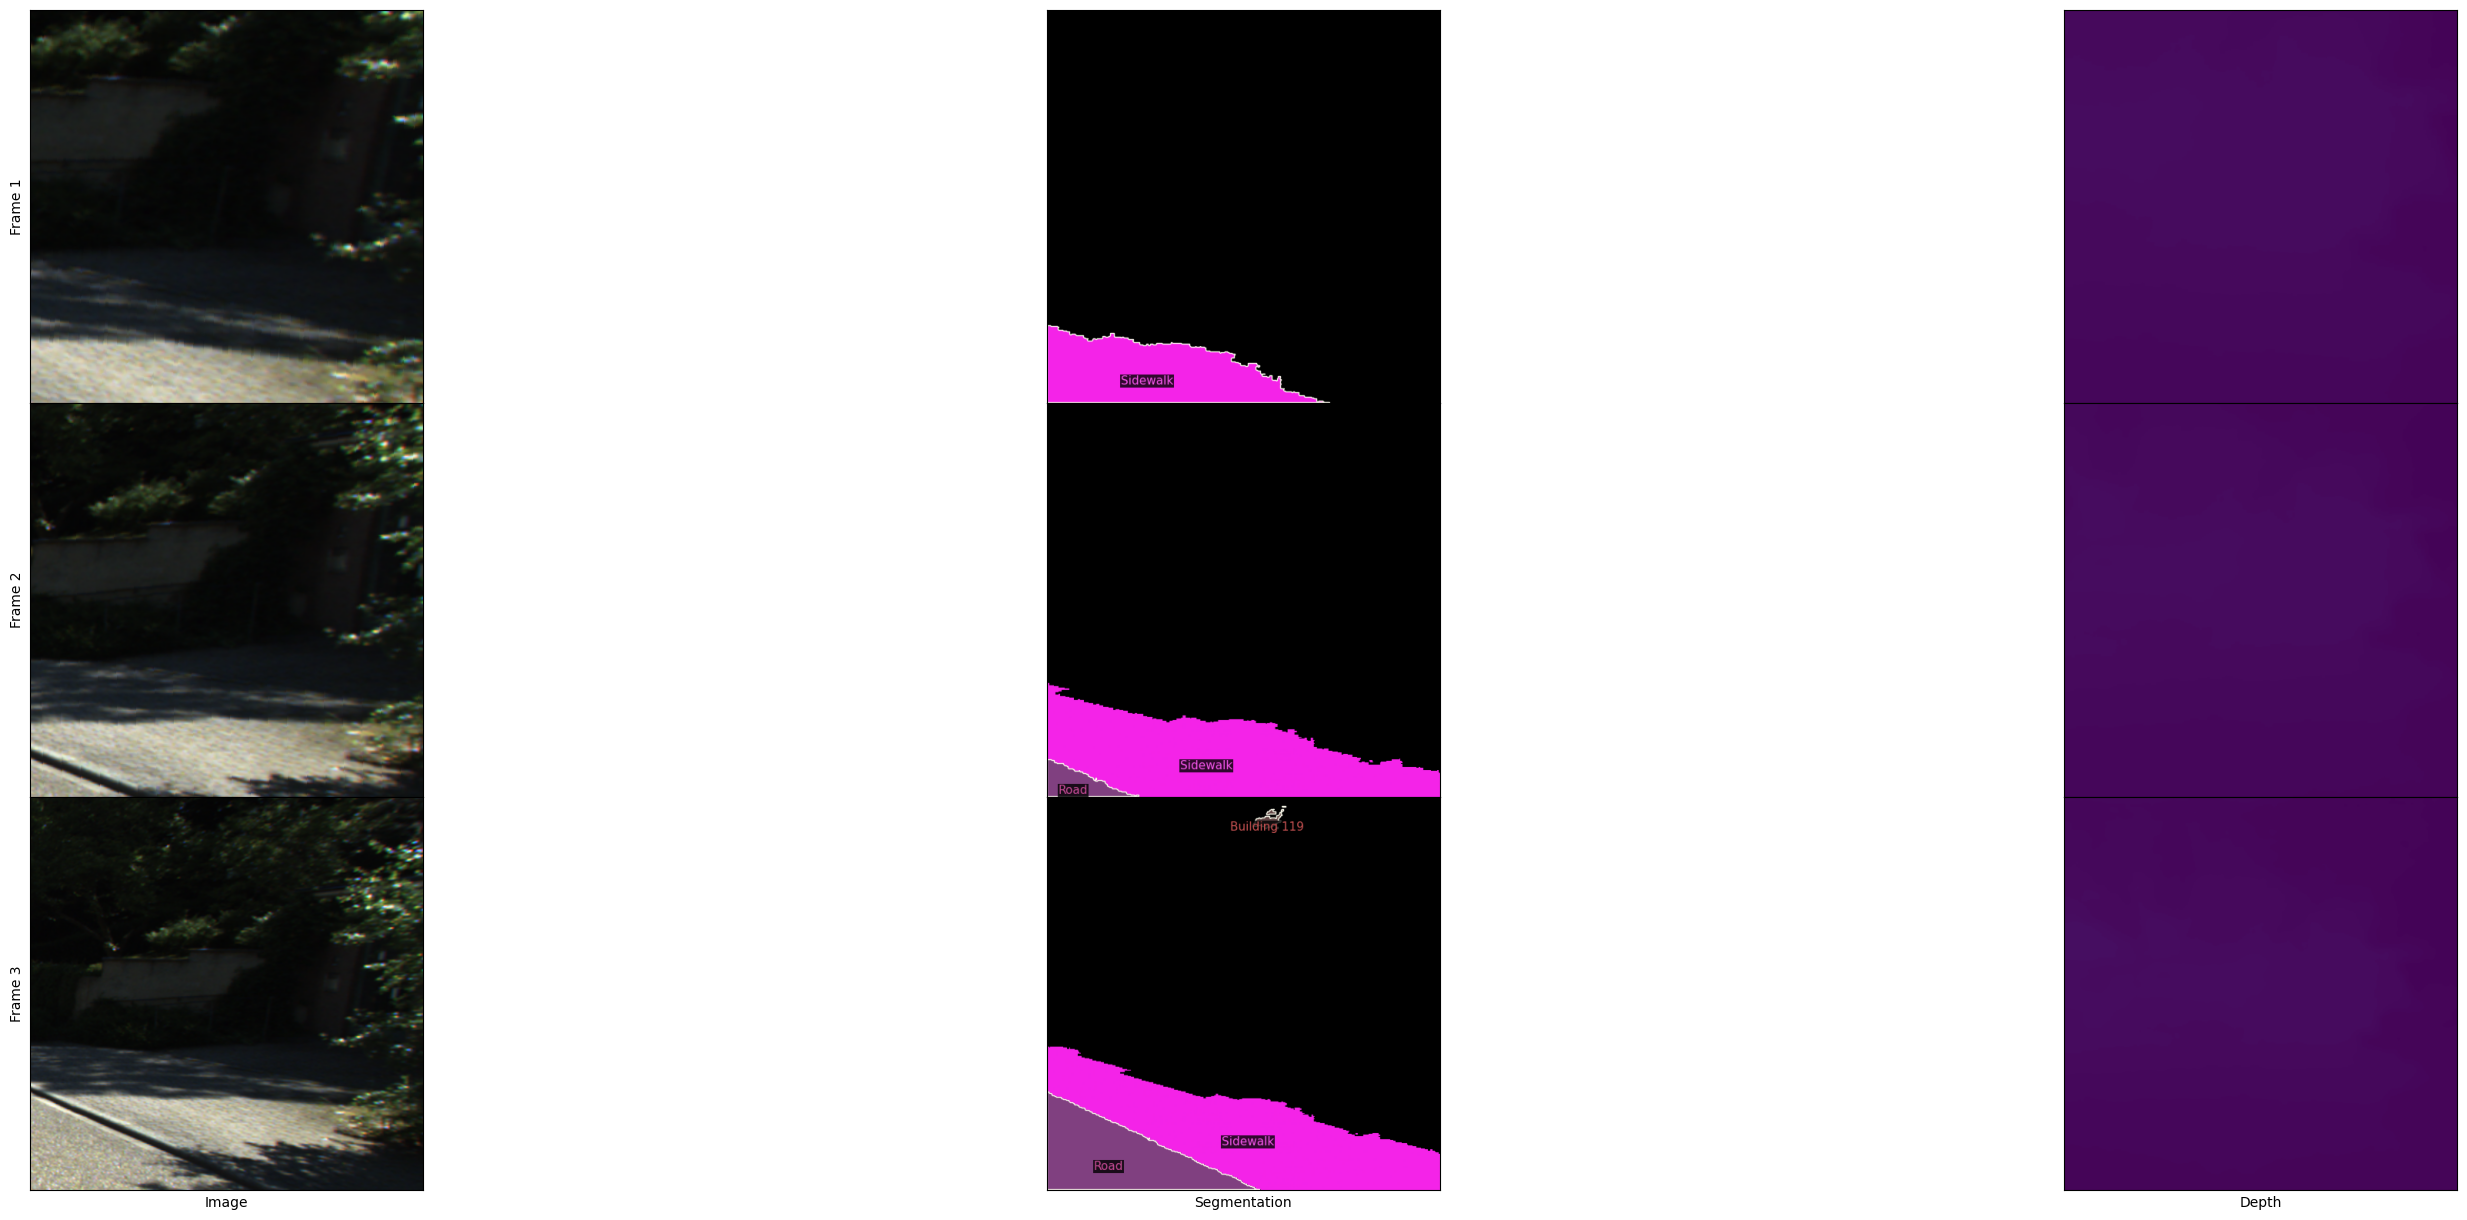

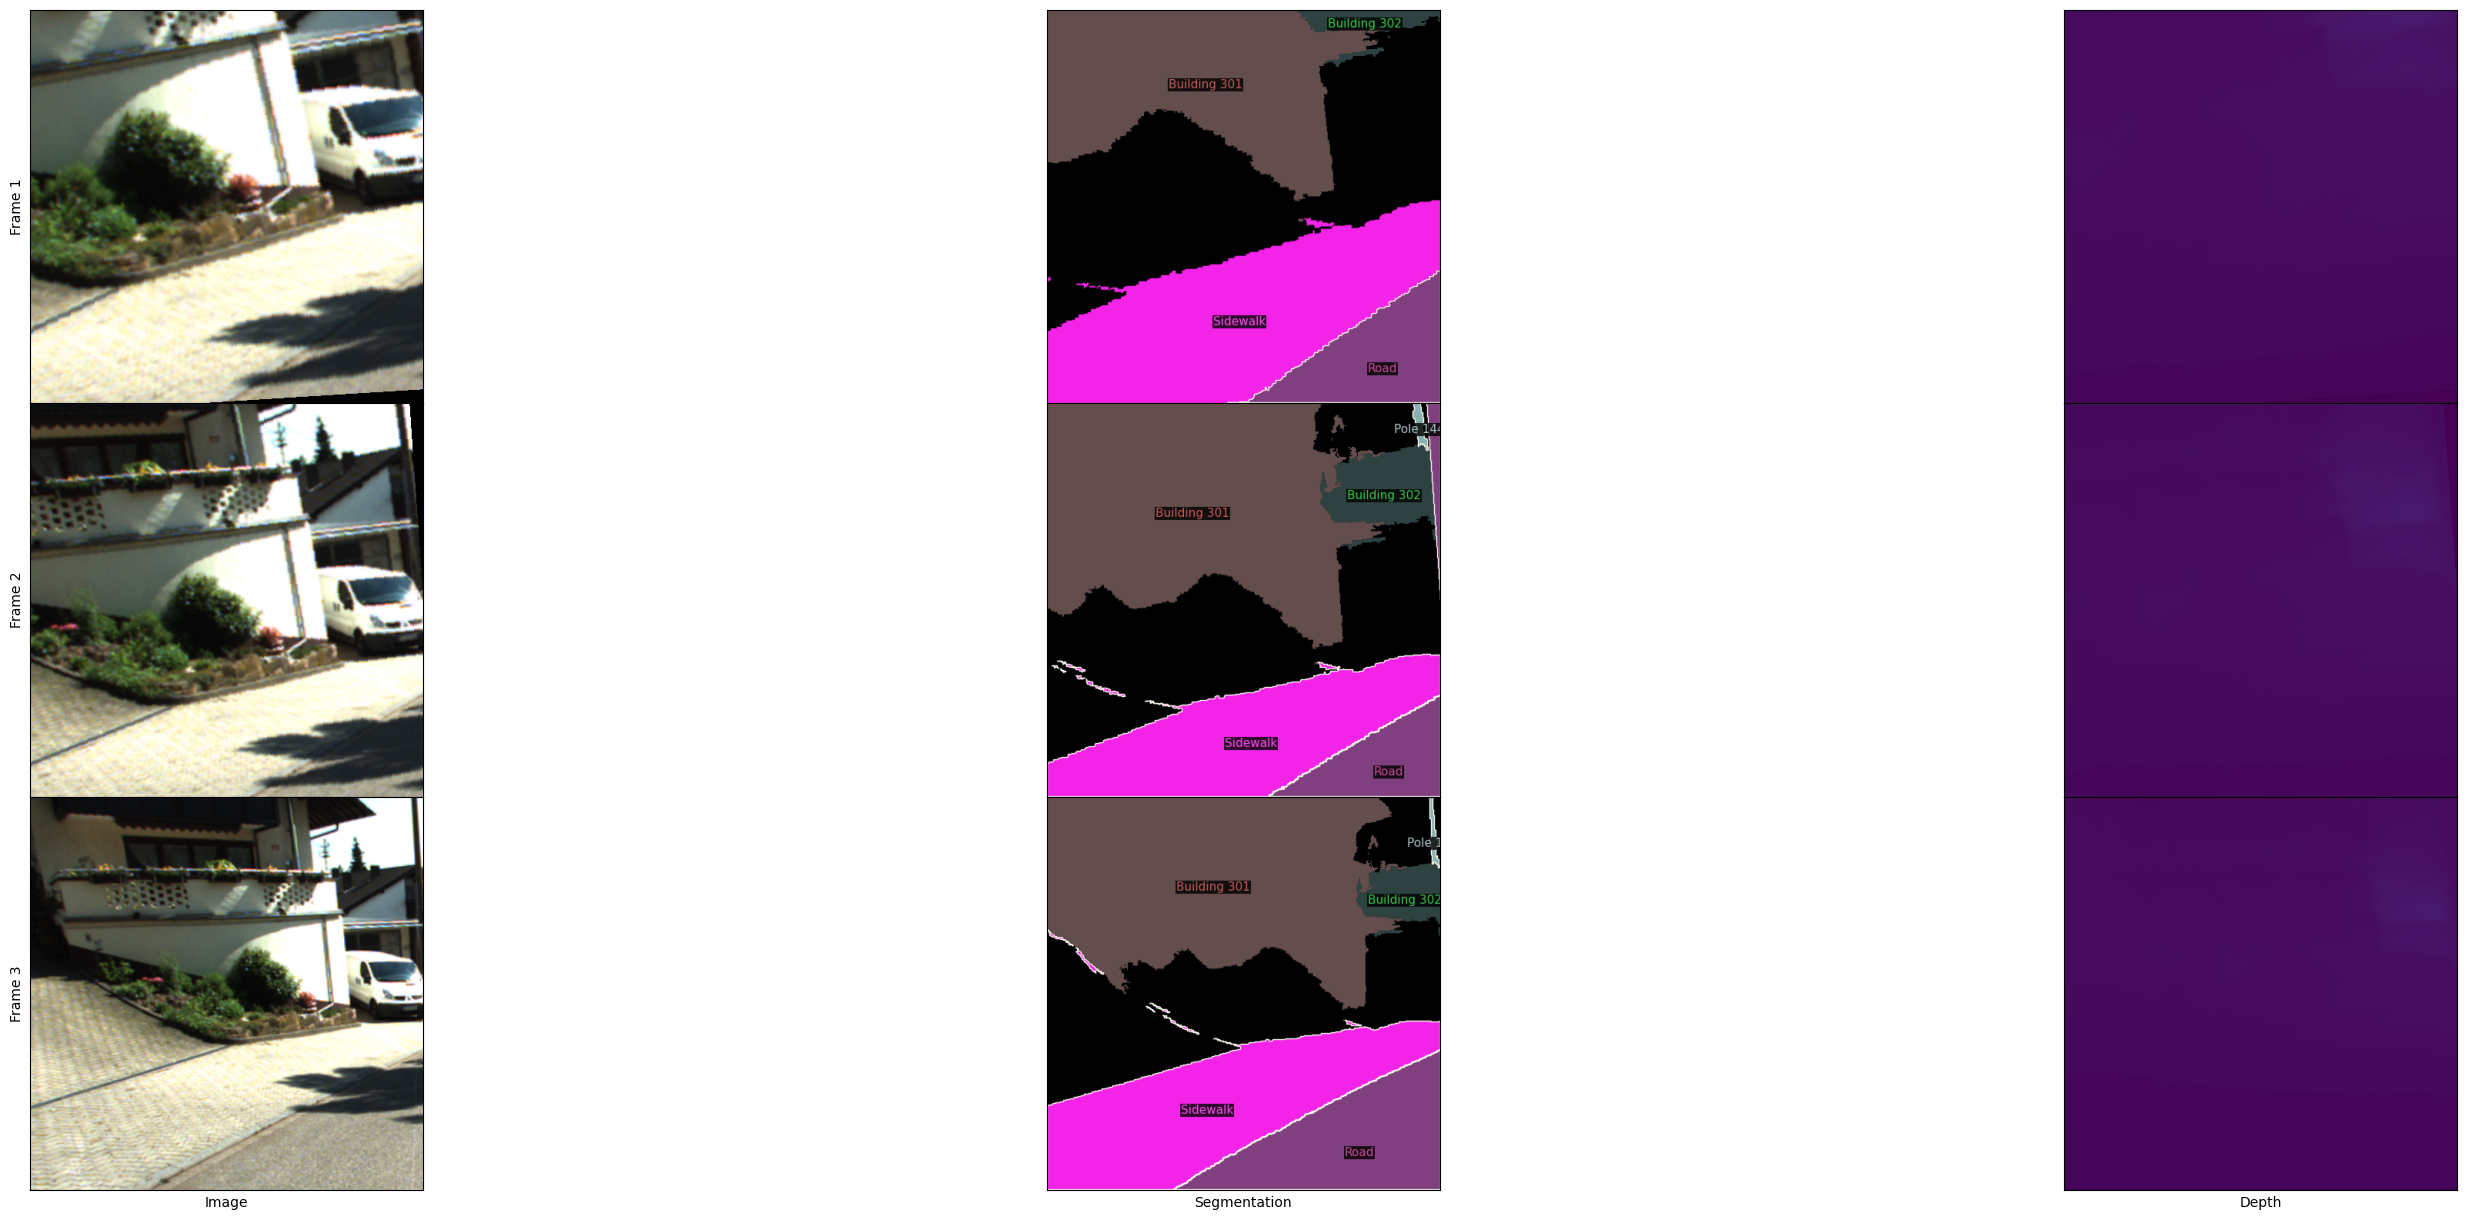

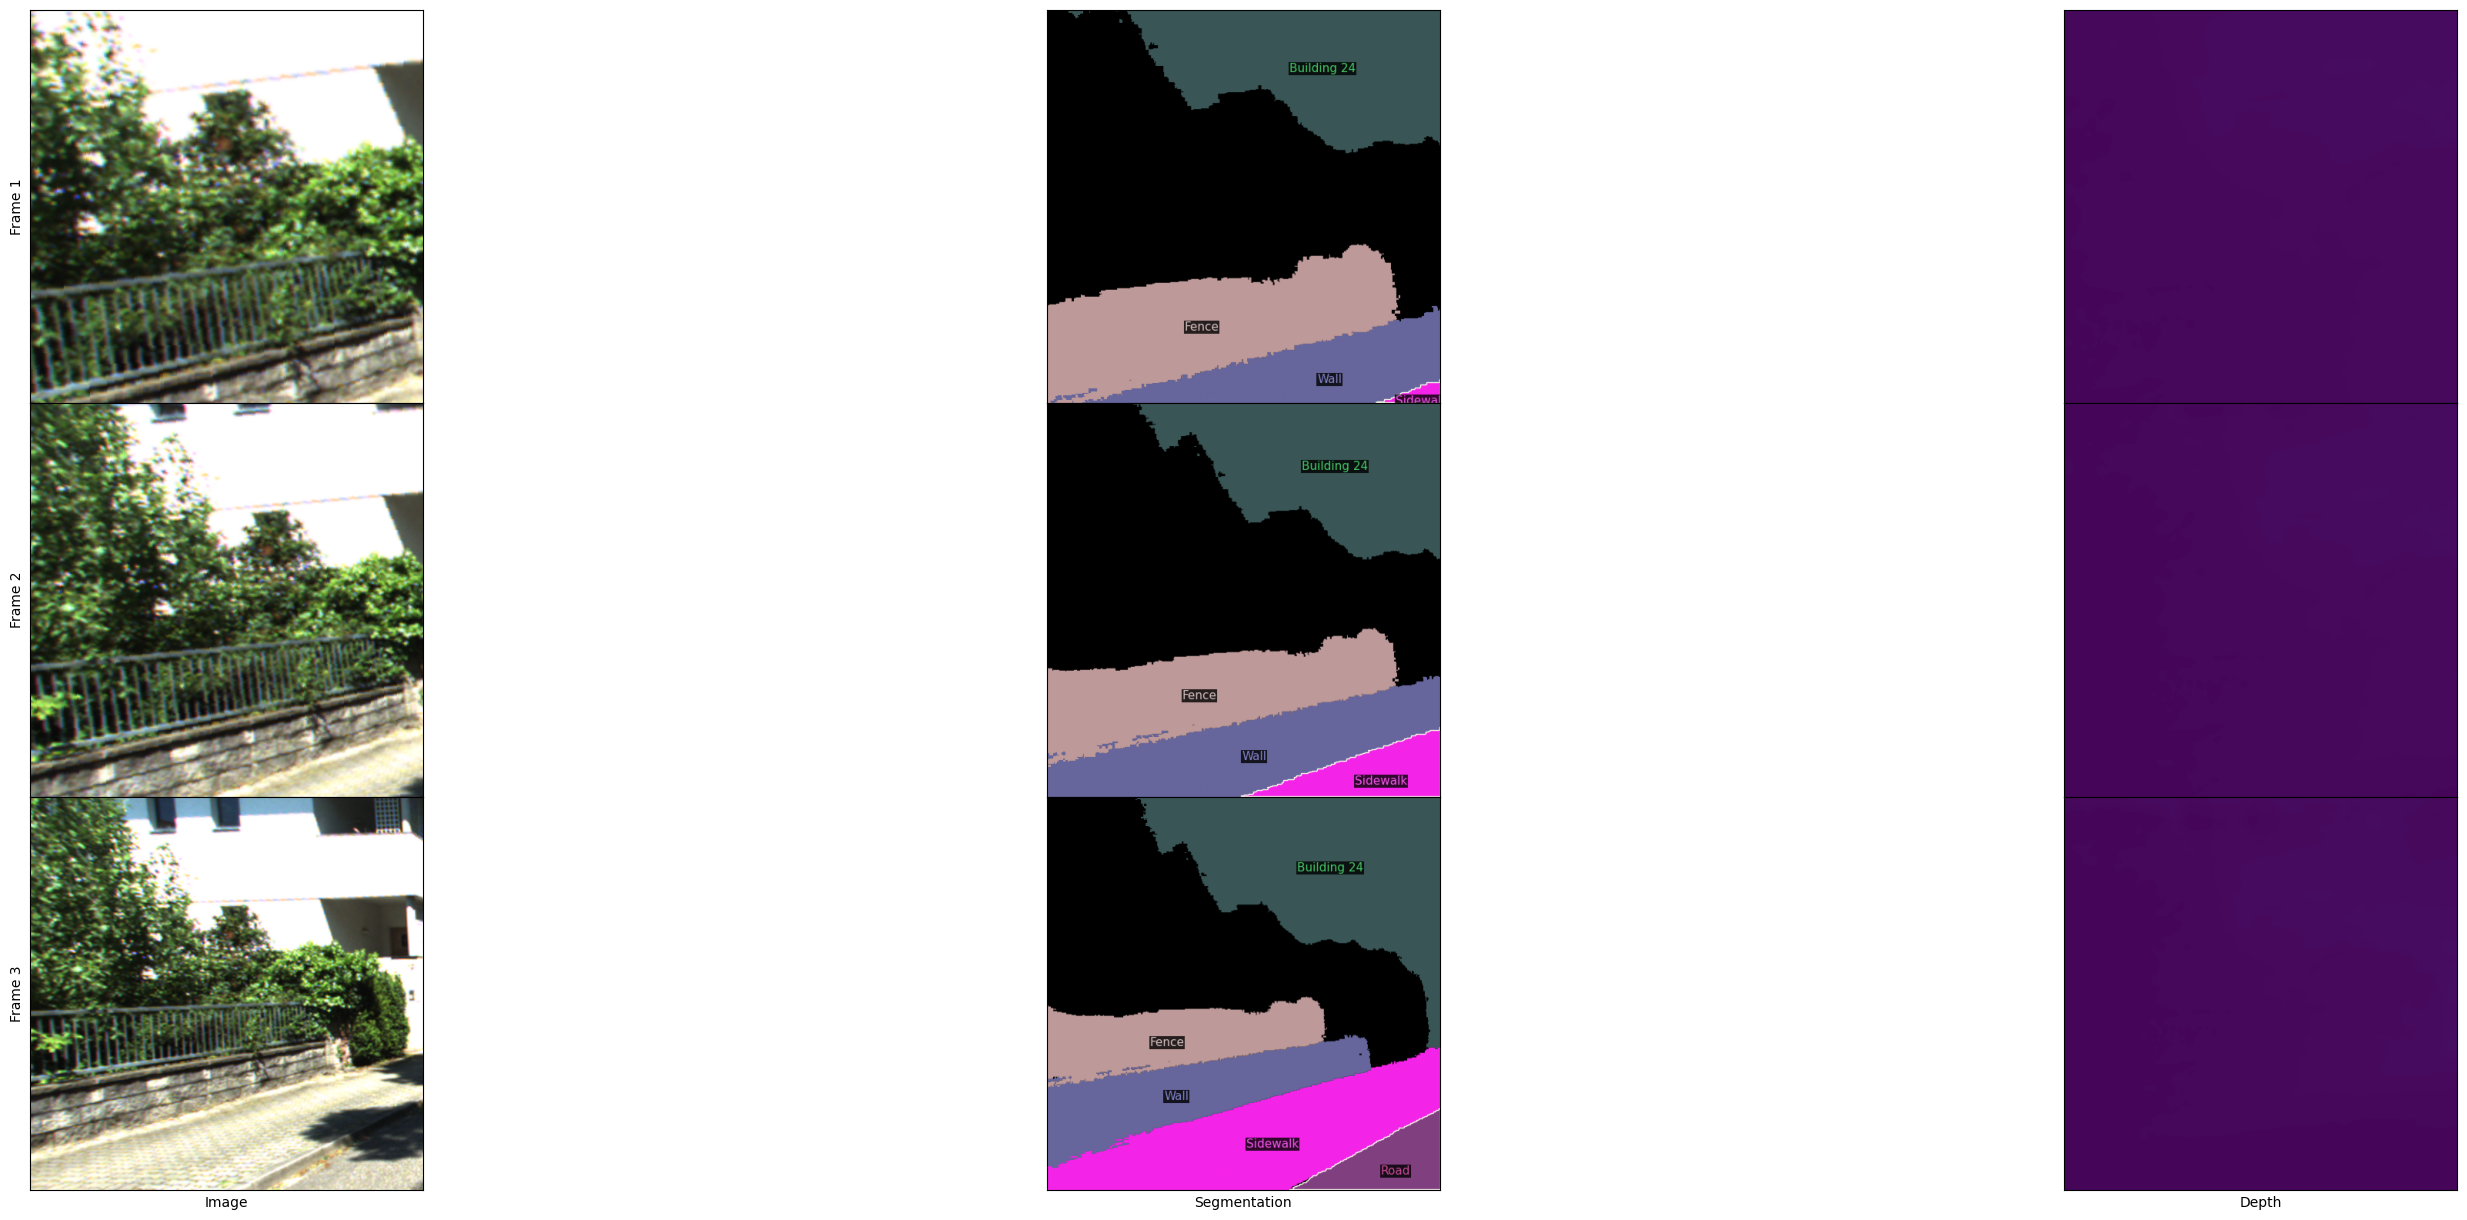

In [8]:
import torch
import unipercept as up
import torchvision.transforms.v2 as tvt2

augment_ops = up.data.ops.TorchvisionOp(tvt2.Resize(size=512, antialias=True))

pseudo_motion = up.data.ops.PseudoMotion(frames=3, size=512)

try:
    for inputs in dp.sample(3):
        inputs = augment_ops(inputs)
        inputs = pseudo_motion(inputs)
        fig = up.render.utils.plot_input_data(inputs, info=ds.info)
except AssertionError as e:
    if "already" in str(e).lower():
        print(f"Skipping! {e}")
    else:
        raise